### 05 ML models

In [287]:
# If you see "Failed building wheel for shap" during shap installation,
# please visit https://visualstudio.microsoft.com/visual-cpp-build-tools/, 
# download and run the installer, 
# then select the "C++ build tools" option and complete the installation.
# Afterward, you can install shap successfully.

%pip install -q shap

Note: you may need to restart the kernel to use updated packages.


In [339]:
%pip install -q imblearn
%pip install -q seaborn
%pip install -q scikit-learn
%pip install -q xgboost
%pip install -q hyperopt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [340]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score 

import xgboost as xgb
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import shap

In [492]:
# Function for feature scaling
def apply_scaling(sc, X_train, X_test, scaling_list):
  int_cols = X_train.drop(columns=scaling_list).columns.tolist()
  int_train = X_train[int_cols]
  int_test = X_test[int_cols]

  float_cols = X_train[scaling_list].columns.to_list()
  float_train = X_train[float_cols]
  float_test = X_test[float_cols]

  scaled_float_train_array = sc.transform(float_train)
  scaled_float_test_array = sc.transform(float_test)

  scaled_float_train = pd.DataFrame(scaled_float_train_array, 
                                    columns=float_cols, 
                                    index=float_train.index)
  scaled_float_test = pd.DataFrame(scaled_float_test_array, 
                                   columns=float_cols, 
                                   index=float_test.index)

  scaled_train = pd.concat([int_train, scaled_float_train], axis=1)
  scaled_test = pd.concat([int_test, scaled_float_test], axis=1)

  return scaled_train, scaled_test


# Function for one-hot encoding 1
def ohe_manual(df):
  df = df.assign(
      WHITE = (df['RACE_CATEGORY'] == 1).astype(int),
      BLACK = (df['RACE_CATEGORY'] == 2).astype(int),
      ASIAN = (df['RACE_CATEGORY'] == 3).astype(int),
      OTHER_RACE = (df['RACE_CATEGORY'] == 4).astype(int)
  )

  df = df.assign(
      MARRIED = (df['MAR_CATEGORY'] == 1).astype(int),
      SEPARATED = (df['MAR_CATEGORY'] == 2).astype(int),
      NEVER_MARRIED = (df['MAR_CATEGORY'] == 3).astype(int)
  )

  df = df.assign(
      HUD_HOU = (df['HUD_CATEGORY'] == 1).astype(int),
      HUD_HCV = (df['HUD_CATEGORY'] == 2).astype(int),
      HUD_NON = (df['HUD_CATEGORY'] == 3).astype(int)
  )

  df = df.assign(
      ONE_FAMILY_HOUSE = (df['UNIT_CATEGORY'] == 1).astype(int),
      APARTMENT = (df['UNIT_CATEGORY'] == 2).astype(int),
      MOBILE_HOUSE = (df['UNIT_CATEGORY'] == 3).astype(int)
  )

  df = df.assign(
      DIV4_1 = (df['DIV4'] == 1).astype(int),
      DIV4_2 = (df['DIV4'] == 2).astype(int),
      DIV4_3 = (df['DIV4'] == 3).astype(int),
      DIV4_4 = (df['DIV4'] == 4).astype(int)
  )

  return df


# Function for one-hot encoding 2 (education level)
def ohe_manual_edu(df):
  df = df.assign(
      UNDSCHOOL = (df['GRAD_CATEGORY'] == 1).astype(int),
      HIGHSCHOOL = (df['GRAD_CATEGORY'] == 2).astype(int),
      COLLEGE = (df['GRAD_CATEGORY'] == 3).astype(int),
      BACHELOR = (df['GRAD_CATEGORY'] == 4).astype(int),
      MASTER = (df['GRAD_CATEGORY'] == 5).astype(int)
  )

  df = df.assign(
      STAY_0_5 = (df['STAY_CATEGORY'] == 1).astype(int),
      STAY_5_10 = (df['STAY_CATEGORY'] == 2).astype(int),
      STAY_10_MORE = (df['STAY_CATEGORY'] == 3).astype(int)
  )

  return df


# Function for grid-search results
def cv_results(gsearch):
  cv_results_df = pd.concat(
    [pd.DataFrame(gsearch.cv_results_["params"]),
     pd.DataFrame(gsearch.cv_results_["rank_test_accuracy"], 
                  columns=["Rank_ACC"]),
     pd.DataFrame(gsearch.cv_results_["mean_train_accuracy"], 
                  columns=["Train Accuracy"]),
     pd.DataFrame(gsearch.cv_results_["mean_test_accuracy"], 
                  columns=["Valid Accuracy"])
     ], axis=1
  ) 

  if 'rank_test_neg_log_loss' in gsearch.cv_results_.keys():
    cv_results_df = pd.concat(
      [cv_results_df,
       pd.DataFrame(gsearch.cv_results_["rank_test_neg_log_loss"], 
                    columns=["Rank_NLL"]),
       pd.DataFrame(gsearch.cv_results_["mean_train_neg_log_loss"], 
                    columns=["Train Neg. Log Loss"]),
       pd.DataFrame(gsearch.cv_results_["mean_test_neg_log_loss"], 
                    columns=["Valid Neg. Log Loss"])
       ], axis=1
    )

  if 'rank_test_roc_auc_ovr' in gsearch.cv_results_.keys():
    cv_results_df = pd.concat(
      [cv_results_df,
       pd.DataFrame(gsearch.cv_results_["rank_test_roc_auc_ovr"], 
                    columns=["Rank_AUC"]),
       pd.DataFrame(gsearch.cv_results_["mean_train_roc_auc_ovr"], 
                    columns=["Train ROC AUC"]),
       pd.DataFrame(gsearch.cv_results_["mean_test_roc_auc_ovr"], 
                    columns=["Valid ROC AUC"])
       ], axis=1
    )

  cv_results_df['diff_ACC'] = \
    cv_results_df['Train Accuracy'] - cv_results_df['Valid Accuracy']

  if 'rank_test_neg_log_loss' in gsearch.cv_results_.keys():
    cv_results_df['diff_NLL'] = \
      cv_results_df['Train Neg. Log Loss'] - cv_results_df['Valid Neg. Log Loss']

  if 'rank_test_roc_auc_ovr' in gsearch.cv_results_.keys():
    cv_results_df['diff_AUC'] = \
      cv_results_df['Train ROC AUC'] - cv_results_df['Valid ROC AUC']

  return cv_results_df


# Function for evaluation metric plots
def eval_plot(cv_results_df, col, col_name):
  dftmp = cv_results_df
  x_axis = dftmp[col]

  if "Train Neg. Log Loss" not in dftmp.columns:
    plt.plot(x_axis, dftmp["Train Accuracy"], label='Train Accuracy')
    plt.plot(x_axis, dftmp["Valid Accuracy"], label='Valid Accuracy')
    plt.xlabel(col_name)
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs {col_name}')
    plt.legend()
    plt.grid(True)

  else:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(x_axis, dftmp["Train Accuracy"], label='Train Accuracy')
    plt.plot(x_axis, dftmp["Valid Accuracy"], label='Valid Accuracy')
    plt.xlabel(col_name)
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs {col_name}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(x_axis, dftmp["Train Neg. Log Loss"], label='Train Neg. Log Loss')
    plt.plot(x_axis, dftmp["Valid Neg. Log Loss"], label='Valid Neg. Log Loss')
    plt.xlabel(col_name)
    plt.ylabel('Neg. Log Loss')
    plt.title(f'Neg. Log Loss vs {col_name}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(x_axis, dftmp["Train ROC AUC"], label='Train ROC AUC')
    plt.plot(x_axis, dftmp["Valid ROC AUC"], label='Valid ROC AUC')
    plt.xlabel(col_name)
    plt.ylabel('ROC AUC')
    plt.title(f'ROC AUC vs {col_name}')
    plt.legend()
    plt.grid(True)

  plt.tight_layout()
  plt.show()


# Function for model report1
def report_for_model1(model, X_train, y_train, X_test, y_test):
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)

  print("\n--- Classification Report for Training Set ---")
  print(classification_report(y_train, train_pred))
  print("\n--- Classification Report for Testing Set ---")
  print(classification_report(y_test, test_pred))

  return train_pred, test_pred


# Function for model report2
def report_for_model2(model, X_train, y_train, X_test, y_test):
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)

  report_train = classification_report(y_train, train_pred, output_dict=True)
  report_train_df = pd.DataFrame(report_train).transpose()
  report_train_df = report_train_df.round(5)

  report_test = classification_report(y_test, test_pred, output_dict=True)
  report_test_df = pd.DataFrame(report_test).transpose()
  report_test_df = report_test_df.round(5)

  print("\n--- Classification Report for Training Set ---")
  print(report_train_df)
  print("\n--- Classification Report for Testing Set ---")
  print(report_test_df)


# Function for ROC AUC scores
def print_auc_scores(model, y_test, X_test):
  print("\n--- Area Under the Receiver Operating Characteristic Curve (ROC AUC) for Testing set ---")
  print("None OvR", roc_auc_score(y_test, model.predict_proba(X_test), 
                                  average=None, multi_class='ovr'))
  print("Macro OvR", roc_auc_score(y_test, model.predict_proba(X_test), 
                                   average='macro', multi_class='ovr'))
  print("Macro OvO", roc_auc_score(y_test, model.predict_proba(X_test), 
                                   average='macro', multi_class='ovo'))
  print("Weighted OvR", roc_auc_score(y_test, model.predict_proba(X_test), 
                                      average='weighted', multi_class='ovr'))
  print("Weighted OvO", roc_auc_score(y_test, model.predict_proba(X_test), 
                                      average='weighted', multi_class='ovo'))


# Results of xgboost grid-search
def xgb_cv_results(xgb_clf, xgb_param_grid, d_train, parameter):
  xgb_cv_results = []

  for p in xgb_param_grid[parameter]:
    xgb_clf.set_params(**{parameter: p})

    cv_results = xgb.cv(
      xgb_clf.get_xgb_params(),
      d_train,
      nfold=5,
      num_boost_round=xgb_clf.get_params()['n_estimators'],
      early_stopping_rounds=xgb_clf.get_params()['early_stopping_rounds'],
      seed=seed
    )

    cv_results['diff_merror'] = \
      cv_results['train-merror-mean'] - cv_results['test-merror-mean']
    cv_results['diff_mlogloss'] = \
      cv_results['train-mlogloss-mean'] - cv_results['test-mlogloss-mean']
    cv_results['diff_auc'] = \
      cv_results['train-auc-mean'] - cv_results['test-auc-mean']

    xgb_cv_results.append({
      parameter: p,
      'best_idx_merror': cv_results['test-merror-mean'].idxmin(),
      'best_train_merror': cv_results.loc[cv_results['test-merror-mean'].idxmin(), 
                                          'train-merror-mean'],
      'best_val_merror': cv_results['test-merror-mean'].min(),
      'diff_merror': cv_results.loc[cv_results['test-merror-mean'].idxmin(), 
                                    'diff_merror'],
      'best_idx_mlogloss': cv_results['test-mlogloss-mean'].idxmin(),
      'best_train_mlogloss': cv_results.loc[cv_results['test-mlogloss-mean'].idxmin(), 
                                            'train-mlogloss-mean'],
      'best_val_mlogloss': cv_results['test-mlogloss-mean'].min(),
      'diff_mlogloss': cv_results.loc[cv_results['test-mlogloss-mean'].idxmin(), 
                                      'diff_mlogloss'],
      'best_idx_auc': cv_results['test-auc-mean'].idxmax(),
      'best_train_auc': cv_results.loc[cv_results['test-auc-mean'].idxmax(), 
                                       'train-auc-mean'],
      'best_val_auc': cv_results['test-auc-mean'].max(),
      'diff_auc': cv_results.loc[cv_results['test-auc-mean'].idxmin(), 
                                 'diff_auc'],
      'boost_rounds': cv_results.shape[0]
    })

  return pd.DataFrame(xgb_cv_results)


# Evaluation metric plots for xgboost
def xgb_eval_plots(xgb_cv_results_df):

  dftmp = xgb_cv_results_df
  x_axis = xgb_cv_results_df.index.tolist()

  plt.figure(figsize=(12, 4))

  plt.subplot(1, 3, 1)
  plt.plot(x_axis, dftmp['train-merror-mean'], label='Train merror')
  plt.plot(x_axis, dftmp['test-merror-mean'], label='Valid merror')
  plt.xlabel('Boosting Round')
  plt.ylabel('Classification Error Rate')
  plt.title('Classification Error Rate vs Boosting Round')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 3, 2)
  plt.plot(x_axis, dftmp['train-mlogloss-mean'], label='Train mlogloss')
  plt.plot(x_axis, dftmp['test-mlogloss-mean'], label='Valid mlogloss')
  plt.xlabel('Boosting Round')
  plt.ylabel('Log Loss')
  plt.title('Log Loss vs Boosting Round')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 3, 3)
  plt.plot(x_axis, dftmp['train-auc-mean'], label='Train auc')
  plt.plot(x_axis, dftmp['test-auc-mean'], label='Valid auc')
  plt.xlabel('Boosting Round')
  plt.ylabel('ROC AUC') 
  plt.title('ROC AUC vs Boosting Round')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()


# Function for Plot of SHAP feature importance
def plot_shap_barplot(shap_values, c, top_n, color, size, xlim, feature_names):
  shap_values_class = shap_values[:, :, c]
  mean_shap_values = np.mean(np.abs(shap_values_class), axis=0)

  sorted_idx = np.argsort(mean_shap_values)[::-1]

  n = top_n
  top_idx = sorted_idx[:n]
  top_mean_shap_values = mean_shap_values[top_idx]
  top_feature_names = feature_names[top_idx]

  plt.figure(figsize=size)
  plt.barh(range(n), top_mean_shap_values, align='center', color=color)
  plt.yticks(range(n), top_feature_names)
  plt.xlim(xlim)
  plt.xlabel('Mean Absolute SHAP Value')

  if c == 3:
      c = '3+'
  plt.title(f'Top {n} Feature Importance\n(Composite Index of Housing Insecurity = {c})')
  plt.gca().invert_yaxis()
  plt.savefig(f'./plots/feature_importance_{c}.png', bbox_inches='tight')
  plt.show()

In [291]:
# Load X and y
X = pd.read_pickle('./temp/X.pkl')
y = pd.read_pickle('./temp/y.pkl')

In [292]:
# Set seed
seed = 57

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=seed, 
                                                    stratify=y)

print("\n--- Sizes of the splited data ---")
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_test:', X_test.shape, 'y_test:', y_test.shape)
print("\n--- Class distribution in training set ---")
print(y_train.value_counts())
print("\n--- Class distribution in test set ---")
print(y_test.value_counts())


--- Sizes of the splited data ---
X_train: (17621, 24) y_train: (17621,)
X_test: (4406, 24) y_test: (4406,)

--- Class distribution in training set ---
COMPOSITE_HI2
0    9064
2    3869
1    3466
3    1222
Name: count, dtype: int64

--- Class distribution in test set ---
COMPOSITE_HI2
0    2266
2     967
1     867
3     306
Name: count, dtype: int64


In [ ]:
# Setting for standardization for numerical features
scaling_list = ['HH_AGE', 'NUM_MEMBERS', 'INCOME', 'LN_INCOME', 'HOUSE_AGE']

sc = StandardScaler()
sc.fit(X_train[X_train[scaling_list].columns.to_list()])

print("\n--- Feature-types for X_train ---")
print(pd.DataFrame({'No.': list(range(len(X_train.dtypes))),
                    'D.types': X_train.dtypes}))


--- Feature-types for X_train ---
                No.  D.types
RACE_CATEGORY     0    int64
LATIN             1    int64
NON_US_CITIZEN    2    int64
HH_AGE            3  float64
MALE              4    int64
GRAD_CATEGORY     5    int64
MAR_CATEGORY      6    int64
YNGKIDS           7    int64
SENIORS           8    int64
DISABLED          9    int64
NUM_MEMBERS      10    int64
INCOME           11  float64
LN_INCOME        12  float64
STAY_CATEGORY    13    int64
HOUSE_AGE        14  float64
UNIT_CATEGORY    15    int64
NOGOODSCHOOL     16    int64
NOGOODPTRNS      17    int64
HIGH_PCRIME      18    int64
HIGH_SCRIME      19    int64
HIGH_RISK        20    int64
RENT_CONTROL     21    int64
HUD_CATEGORY     22    int64
DIV4             23    int64


In [ ]:
# Undersampling
rus = RandomUnderSampler(
    sampling_strategy={y_train.value_counts().index[0]: y_train.value_counts().iloc[1]}, 
    random_state=seed
)

X_rus, y_rus = rus.fit_resample(X_train, y_train)

print("\n--- The number of each class after under-sampling ---")
print(y_rus.value_counts())


--- The number of each class after under-sampling ---
COMPOSITE_HI2
0    3869
2    3869
1    3466
3    1222
Name: count, dtype: int64


In [ ]:
# Oversampling (SMOTE-NC)
smote_nc = SMOTENC(
    categorical_features=[0,1,2,4,5,6,7,8,9,10,13,15,16,17,18,19,20,21,22,23], 
    random_state=seed
) # 3,11,12,14 are continuous

X_res, y_res = smote_nc.fit_resample(X_rus, y_rus)

print("\n--- The number of each class after over-sampling ---")
print(y_res.value_counts())


--- The number of each class after over-sampling ---
COMPOSITE_HI2
0    3869
1    3869
2    3869
3    3869
Name: count, dtype: int64


In [ ]:
# One-hot encoding 1
X_res_ohe = ohe_manual(X_res)
X_test_ohe = ohe_manual(X_test)

X_res_ohe.drop(['RACE_CATEGORY', 'MAR_CATEGORY', 'UNIT_CATEGORY', 'HUD_CATEGORY', 'DIV4'], 
               axis=1, inplace=True)
X_test_ohe.drop(['RACE_CATEGORY', 'MAR_CATEGORY', 'UNIT_CATEGORY', 'HUD_CATEGORY', 'DIV4'], 
                axis=1, inplace=True)

In [ ]:
# Standardization for numerical features
X_res_ohe_scaled, X_test_ohe_scaled = apply_scaling(sc, 
                                                    X_res_ohe, X_test_ohe, 
                                                    scaling_list)

print("\n--- Check after standardization ---")
print("X_res_ohe:", X_res_ohe.shape, 
      " --> X_res_ohe_scaled:", X_res_ohe_scaled.shape)
print("X_test_ohe:", X_test_ohe.shape, 
      " --> X_test_ohe_scaled:", X_test_ohe_scaled.shape)

print("\n--- Summary statistics for countinuous features in X_train after standardization ---")
print(X_res_ohe_scaled[X_res_ohe_scaled.select_dtypes(include=['float']).columns.to_list()].describe())

print("\n--- Summary statistics for countinuous features in X_test after standardization ---")
print(X_test_ohe_scaled[X_test_ohe_scaled.select_dtypes(include=['float']).columns.to_list()].describe())



--- Check after standardization ---
X_res_ohe: (15476, 36)  --> X_res_ohe_scaled: (15476, 36)
X_test_ohe: (4406, 36)  --> X_test_ohe_scaled: (4406, 36)

--- Summary statistics for countinuous features in X_train after standardization ---
             HH_AGE   NUM_MEMBERS        INCOME     LN_INCOME     HOUSE_AGE
count  15476.000000  15476.000000  15476.000000  15476.000000  15476.000000
mean       0.027482     -0.033246     -0.210706     -0.282977      0.068935
std        0.973784      0.999609      0.733924      1.167570      0.973613
min       -1.899795     -0.826420     -0.700316     -4.265119     -1.881454
25%       -0.794976     -0.826420     -0.577223     -0.331116     -0.738746
50%       -0.038340     -0.150736     -0.438415     -0.006470     -0.001515
75%        0.793139      0.524949     -0.101871      0.348865      0.735717
max        2.048745     11.335898     18.824438      1.847496      1.878425

--- Summary statistics for countinuous features in X_test after standardizat

In [299]:
# Drop one of the dummies
remove_features = ['WHITE', 'NEVER_MARRIED', 'APARTMENT', 'HUD_NON', 'DIV4_3']

X_res_ohe.drop(remove_features, axis=1, inplace=True)
X_test_ohe.drop(remove_features, axis=1, inplace=True)

X_res_ohe_scaled.drop(remove_features, axis=1, inplace=True)
X_test_ohe_scaled.drop(remove_features, axis=1, inplace=True)

In [ ]:
# One-hot encoding 2 (education level)
X_res_ohe_scaled = ohe_manual_edu(X_res_ohe_scaled)
X_test_ohe_scaled = ohe_manual_edu(X_test_ohe_scaled)

X_res_ohe_scaled.drop(['COLLEGE', 'GRAD_CATEGORY', 'STAY_0_5', 'STAY_CATEGORY'], 
                      axis=1, inplace=True)
X_test_ohe_scaled.drop(['COLLEGE', 'GRAD_CATEGORY', 'STAY_0_5', 'STAY_CATEGORY'], 
                       axis=1, inplace=True)

In [301]:
# Rename features
rename_dict0 = {'RACE_CATEGORY': 'Race', 'MAR_CATEGORY': 'Marital_status', 'UNIT_CATEGORY': 'Unit_type', 'HUD_CATEGORY': 'HUD_assisted_type', 'DIV4': 'Divisions'}
rename_dict = {'WHITE': 'White', 'BLACK': 'Black', 'ASIAN': 'Asian', 'OTHER_RACE': 'Other_races',
               'LATIN': 'Spanish_origin', 'NON_US_CITIZEN': 'Non_US_citizen',
               'HH_AGE': 'Householder_age', 'MALE': 'Male',
               'GRAD_CATEGORY': 'Education_level', 'UNDSCHOOL': 'Below_highschool', 'HIGHSCHOOL': 'Highschool', 'COLLEGE': 'College', 'BACHELOR': 'Bachelor', 'MASTER': 'Master_PhD',
               'MARRIED': 'Married', 'SEPARATED': 'Separated', 'NEVER_MARRIED': 'Never_married',
               'YNGKIDS': 'Presence_of_young_children', 'SENIORS': 'Presence_of_seniors', 'DISABLED': 'Presence_of_disabled_members', 'NUM_MEMBERS': 'Number_of_household_members',
               'INCOME': 'Income', 'LN_INCOME': 'ln_Income',
               'STAY_CATEGORY': 'Length_of_stay', 'STAY_5_10': 'Stay_5_9_years', 'STAY_10_MORE': 'Stay_10_years_or_more',
               'HOUSE_AGE': 'Age_of_house',
               'ONE_FAMILY_HOUSE': 'One_family_house', 'APARTMENT': 'Apartment', 'MOBILE_HOUSE': 'Mobile_house',
               'NOGOODSCHOOL': 'No_good_schools', 'NOGOODPTRNS': 'No_good_public_transportation', 'HIGH_PCRIME': 'High_levels_of_petty_crime', 'HIGH_SCRIME': 'High_levels_of_serious_crime', 'HIGH_RISK': 'High_disaster_risk',
               'RENT_CONTROL': 'Rent_controlled', 'HUD_HOU': 'Subsidized_unit', 'HUD_HCV': 'Rent_assisted_unit', 'HUD_NON': 'Unassisted_unit',
               'DIV4_1': 'Northeast_(Division1)', 'DIV4_2': 'Midwest_(Division2)', 'DIV4_3': 'South_(Division3)', 'DIV4_4': 'West_(Division4)'}

X_res.rename(columns=rename_dict0, inplace=True)
X_test.rename(columns=rename_dict0, inplace=True)

X_res.rename(columns=rename_dict, inplace=True)
X_test.rename(columns=rename_dict, inplace=True)

X_res_ohe.rename(columns=rename_dict, inplace=True)
X_test_ohe.rename(columns=rename_dict, inplace=True)

X_res_ohe_scaled.rename(columns=rename_dict, inplace=True)
X_test_ohe_scaled.rename(columns=rename_dict, inplace=True)

In [302]:
# Choose 'ln_Income' (rather than 'Income')
X_res.drop('Income', axis=1, inplace=True)
X_test.drop('Income', axis=1, inplace=True)

X_res_ohe.drop('Income', axis=1, inplace=True)
X_test_ohe.drop('Income', axis=1, inplace=True)

X_res_ohe_scaled.drop('Income', axis=1, inplace=True)
X_test_ohe_scaled.drop('Income', axis=1, inplace=True)

In [ ]:
# Check the numbers of rows and columns
print("\n--- Check data ---")
print('X_res:', X_res.shape, 'y_res:', y_res.shape, 
      'X_test:', X_test.shape, 'y_test:', y_test.shape)
print('X_res_ohe:', X_res_ohe.shape, 'y_res:', y_res.shape, 
      'X_test_ohe:', X_test_ohe.shape, 'y_test:', y_test.shape)
print('X_res_ohe_scaled:', X_res_ohe_scaled.shape, 'y_res:', y_res.shape, 
      'X_test_ohe_scaled:', X_test_ohe_scaled.shape, 'y_test:', y_test.shape)



--- Check data ---
X_res: (15476, 23) y_res: (15476,) X_test: (4406, 23) y_test: (4406,)
X_res_ohe: (15476, 30) y_res: (15476,) X_test_ohe: (4406, 30) y_test: (4406,)
X_res_ohe_scaled: (15476, 34) y_res: (15476,) X_test_ohe_scaled: (4406, 34) y_test: (4406,)


In [304]:
# Check variables for X_res and X_test
print("Are the columns of X_res and X_test the same?:", 
      sorted(X_res.columns) == sorted(X_test.columns))
print("\n--- Check variables: X_res ans X_test ---")
print(X_res.columns)

Are the columns of X_res and X_test the same?: True

--- Check variables: X_res ans X_test ---
Index(['Race', 'Spanish_origin', 'Non_US_citizen', 'Householder_age', 'Male',
       'Education_level', 'Marital_status', 'Presence_of_young_children',
       'Presence_of_seniors', 'Presence_of_disabled_members',
       'Number_of_household_members', 'ln_Income', 'Length_of_stay',
       'Age_of_house', 'Unit_type', 'No_good_schools',
       'No_good_public_transportation', 'High_levels_of_petty_crime',
       'High_levels_of_serious_crime', 'High_disaster_risk', 'Rent_controlled',
       'HUD_assisted_type', 'Divisions'],
      dtype='object')


In [305]:
# Check variables for X_res_ohe and X_test_ohe
print("Are the columns of X_res_ohe and X_test_ohe the same?:", 
      sorted(X_res_ohe.columns) == sorted(X_test_ohe.columns))
print("\n--- Check variables: X_res_ohe and X_test_ohe ---")
print(X_res_ohe.columns)

Are the columns of X_res_ohe and X_test_ohe the same?: True

--- Check variables: X_res_ohe and X_test_ohe ---
Index(['Spanish_origin', 'Non_US_citizen', 'Householder_age', 'Male',
       'Education_level', 'Presence_of_young_children', 'Presence_of_seniors',
       'Presence_of_disabled_members', 'Number_of_household_members',
       'ln_Income', 'Length_of_stay', 'Age_of_house', 'No_good_schools',
       'No_good_public_transportation', 'High_levels_of_petty_crime',
       'High_levels_of_serious_crime', 'High_disaster_risk', 'Rent_controlled',
       'Black', 'Asian', 'Other_races', 'Married', 'Separated',
       'Subsidized_unit', 'Rent_assisted_unit', 'One_family_house',
       'Mobile_house', 'Northeast_(Division1)', 'Midwest_(Division2)',
       'West_(Division4)'],
      dtype='object')


In [306]:
# Check variables for X_res_ohe_scaled and X_test_ohe_scaled
print("Are the columns of X_res_ohe_scaled and X_test_ohe_scaled the same?:", 
      sorted(X_res_ohe_scaled.columns) == sorted(X_test_ohe_scaled.columns))
print("\n--- Check variables: X_res_ohe_scaled and X_test_ohe_scaled ---")
print(X_res_ohe_scaled.columns)

Are the columns of X_res_ohe_scaled and X_test_ohe_scaled the same?: True

--- Check variables: X_res_ohe_scaled and X_test_ohe_scaled ---
Index(['Spanish_origin', 'Non_US_citizen', 'Male',
       'Presence_of_young_children', 'Presence_of_seniors',
       'Presence_of_disabled_members', 'No_good_schools',
       'No_good_public_transportation', 'High_levels_of_petty_crime',
       'High_levels_of_serious_crime', 'High_disaster_risk', 'Rent_controlled',
       'Black', 'Asian', 'Other_races', 'Married', 'Separated',
       'Subsidized_unit', 'Rent_assisted_unit', 'One_family_house',
       'Mobile_house', 'Northeast_(Division1)', 'Midwest_(Division2)',
       'West_(Division4)', 'Householder_age', 'Number_of_household_members',
       'ln_Income', 'Age_of_house', 'Below_highschool', 'Highschool',
       'Bachelor', 'Master_PhD', 'Stay_5_9_years', 'Stay_10_years_or_more'],
      dtype='object')


In [ ]:
# Undersampling for tuning
rus_1 = RandomUnderSampler(
  sampling_strategy={0: 200, 1: 200, 2: 200, 3: 200}, random_state=seed
)
X_res_ohe_rus_1, y_res_rus_1 = rus_1.fit_resample(X_res_ohe_scaled, y_res)

##### 05_1 Random Forest

In [307]:
rf_clf = RandomForestClassifier(bootstrap=True, random_state=seed)

In [ ]:
# Grid-search for random forest_0
rf_gsearch0 = GridSearchCV(
    param_grid={'n_estimators': list(range(100, 2001, 100)),
                'max_features': [None],
                'max_leaf_nodes': [None],
                'max_depth': [None],
                'max_samples': [None],
                'min_samples_split': [2],
                'min_samples_leaf': [1]},
    estimator=rf_clf,
    cv=5,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

rf_gsearch0.fit(X_res_ohe_scaled, y_res)

rf_cv_results_df0 = cv_results(rf_gsearch0)
rf_cv_results_df0.sort_values(by="Rank_ACC", ascending=True)

,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
14,None,None,None,None,1,2,1500,1,1.0,0.658123,5,-0.191265,-0.831561,5,1.0,0.879608,0.341877,0.640296,0.120392
13,None,None,None,None,1,2,1400,2,1.0,0.658058,8,-0.191237,-0.833392,6,1.0,0.879596,0.341942,0.642155,0.120404
12,None,None,None,None,1,2,1300,3,1.0,0.657670,7,-0.191265,-0.833316,8,1.0,0.879593,0.342330,0.642051,0.120407
15,None,None,None,None,1,2,1600,4,1.0,0.657412,6,-0.191226,-0.831565,7,1.0,0.879594,0.342588,0.640340,0.120406
19,None,None,None,None,1,2,2000,5,1.0,0.657218,1,-0.191259,-0.827634,2,1.0,0.879647,0.342782,0.636375,0.120353
18,None,None,None,None,1,2,1900,6,1.0,0.657154,3,-0.191257,-0.827706,3,1.0,0.879645,0.342846,0.636450,0.120355
11,None,None,None,None,1,2,1200,7,1.0,0.657024,10,-0.191278,-0.837196,9,1.0,0.879566,0.342976,0.645918,0.120434
17,None,None,None,None,1,2,1800,8,1.0,0.656830,2,-0.191246,-0.827650,1,1.0,0.879661,0.343170,0.636404,0.120339
16,None,None,None,None,1,2,1700,9,1.0,0.656766,4,-0.191230,-0.829638,4,1.0,0.879615,0.343234,0.638408,0.120385
5,None,None,None,None,1,2,600,10,1.0,0.656766,15,-0.191292,-0.853021,15,1.0,0.879406,0.343234,0.661729,0.120594


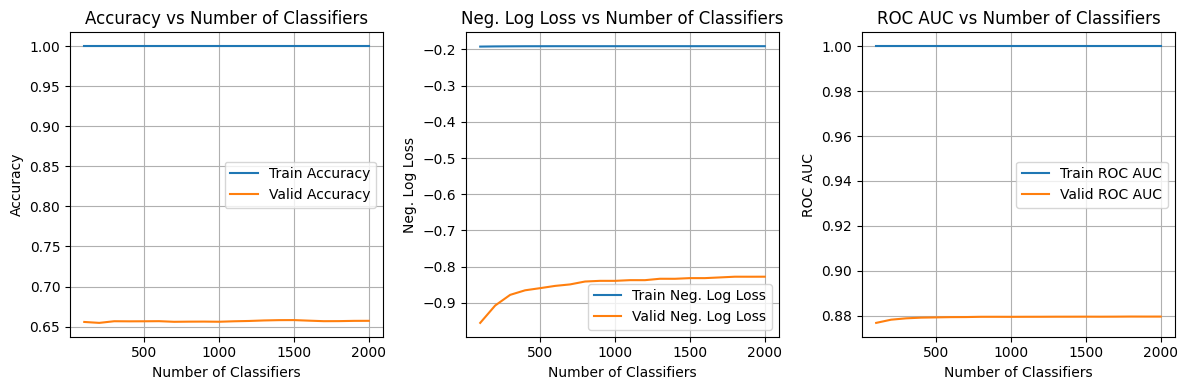

{'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1500}


In [310]:
# Evaluation plots for grid-search for random forest_0
eval_plot(rf_cv_results_df0, 'n_estimators', 'Number of Classifiers')
print(rf_gsearch0.best_params_)

In [ ]:
# Grid-search for random forest_1
rf_gsearch1 = GridSearchCV(
    param_grid={'n_estimators': [800],
                'max_features': [None],
                'max_leaf_nodes': [None],
                'max_depth': [2, 3, 4, 5, 6, 7, 8, 
                                9, 10, 11, 12, 13, 14, 
                                15, 16, 17, 18, 19, 20],
                'max_samples': [None],
                'min_samples_split': [2],
                'min_samples_leaf': [1]},
    estimator=rf_clf,
    cv=5,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
    )

rf_gsearch1.fit(X_res_ohe_scaled, y_res)

rf_cv_results_df1 = cv_results(rf_gsearch1)
rf_cv_results_df1.sort_values(by="Rank_ACC", ascending=True)

,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
18,20,None,None,None,1,2,800,1,0.998950,0.657412,9,-0.205865,-0.840674,1,0.999998,0.879456,0.341538,0.634809,0.120542
16,18,None,None,None,1,2,800,2,0.994782,0.656637,3,-0.227609,-0.832424,3,0.999952,0.879242,0.338146,0.604814,0.120710
17,19,None,None,None,1,2,800,3,0.997577,0.656378,5,-0.214647,-0.833752,2,0.999989,0.879309,0.341199,0.619105,0.120681
14,16,None,None,None,1,2,800,4,0.980874,0.655409,7,-0.272147,-0.834057,5,0.999361,0.878733,0.325465,0.561910,0.120628
15,17,None,None,None,1,2,800,5,0.989839,0.655344,4,-0.246236,-0.832876,4,0.999808,0.878998,0.334495,0.586639,0.120811
13,15,None,None,None,1,2,800,6,0.965269,0.654439,1,-0.307002,-0.828091,6,0.998184,0.878190,0.310829,0.521089,0.119994
12,14,None,None,None,1,2,800,7,0.943105,0.654181,2,-0.351958,-0.829757,7,0.995491,0.877316,0.288925,0.477799,0.118175
11,13,None,None,None,1,2,800,8,0.912881,0.650045,6,-0.407818,-0.833882,8,0.990092,0.876070,0.262836,0.426064,0.114022
10,12,None,None,None,1,2,800,9,0.875840,0.645587,8,-0.473942,-0.839967,9,0.980610,0.874214,0.230253,0.366025,0.106396
9,11,None,None,None,1,2,800,10,0.832337,0.640352,10,-0.548086,-0.848233,10,0.966090,0.871684,0.191985,0.300147,0.094406


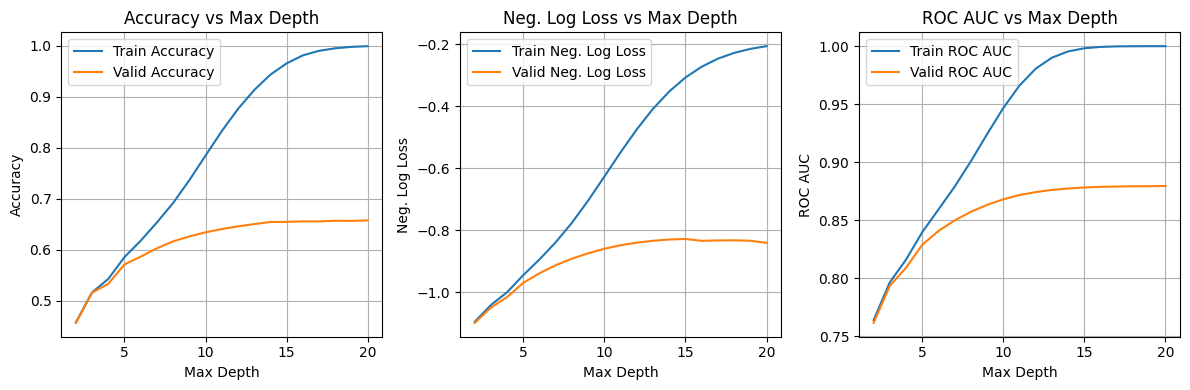

{'max_depth': 20, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


In [312]:
# Evaluation plots for grid-search for random forest_1
eval_plot(rf_cv_results_df1, 'max_depth', 'Max Depth')
print(rf_gsearch1.best_params_)

In [ ]:
# Grid-search for random forest_2
rf_gsearch2 = GridSearchCV(
    param_grid={'n_estimators': [800],
                'max_features': [None],
                'max_leaf_nodes': list(range(10, 101, 10)),
                'max_depth': [7],
                'max_samples': [None],
                'min_samples_split': [2],
                'min_samples_leaf': [1]},
    estimator=rf_clf,
    cv=5,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

rf_gsearch2.fit(X_res_ohe_scaled, y_res)

rf_cv_results_df2 = cv_results(rf_gsearch2)
rf_cv_results_df2.sort_values(by="Rank_ACC", ascending=True)

,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
8,7,None,90,None,1,2,800,1,0.646146,0.603325,2,-0.852131,-0.915249,2,0.873863,0.849055,0.042821,0.063118,0.024808
7,7,None,80,None,1,2,800,2,0.642334,0.603260,3,-0.859286,-0.917378,3,0.871276,0.848364,0.039073,0.058092,0.022912
9,7,None,100,None,1,2,800,3,0.649377,0.602937,1,-0.846174,-0.913882,1,0.876062,0.849481,0.046439,0.067708,0.026582
6,7,None,70,None,1,2,800,4,0.637487,0.602679,4,-0.867782,-0.920317,4,0.868209,0.847413,0.034808,0.052535,0.020797
5,7,None,60,None,1,2,800,5,0.631930,0.599771,5,-0.877908,-0.924601,5,0.864555,0.845958,0.032159,0.046693,0.018597
4,7,None,50,None,1,2,800,6,0.624144,0.596023,6,-0.890332,-0.930433,6,0.860037,0.843961,0.028121,0.040101,0.016077
3,7,None,40,None,1,2,800,7,0.614775,0.592663,7,-0.906071,-0.938933,7,0.854372,0.841072,0.022112,0.032862,0.013299
2,7,None,30,None,1,2,800,8,0.605050,0.586201,8,-0.926586,-0.951684,8,0.847184,0.836780,0.018849,0.025099,0.010403
1,7,None,20,None,1,2,800,9,0.590592,0.575862,9,-0.953921,-0.971883,9,0.837233,0.829475,0.014730,0.017962,0.007758
0,7,None,10,None,1,2,800,10,0.546524,0.540710,10,-1.007362,-1.017021,10,0.815563,0.810971,0.005814,0.009659,0.004592


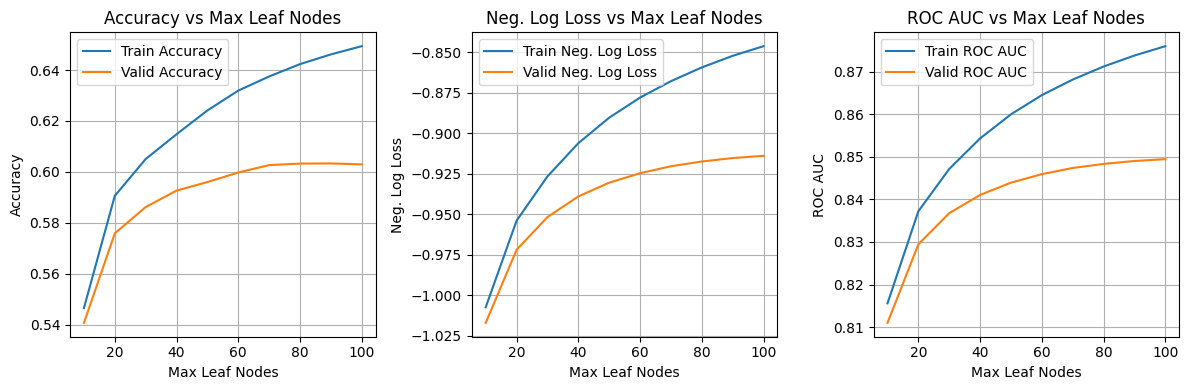

{'max_depth': 7, 'max_features': None, 'max_leaf_nodes': 90, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


In [314]:
# Evaluation plots for grid-search for random forest_2
eval_plot(rf_cv_results_df2, 'max_leaf_nodes', 'Max Leaf Nodes')
print(rf_gsearch2.best_params_)

In [ ]:
# Grid-search for random forest_3
rf_gsearch3 = GridSearchCV(
    param_grid={'n_estimators': [800],
                'max_features': [0.05, 0.1, 0.15, 0.2, 0.25, 
                                0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 
                                0.8, 0.85, 0.9, 0.95, 1.0],
                'max_leaf_nodes': [30],
                'max_depth': [7],
                'max_samples': [None],
                'min_samples_split': [2],
                'min_samples_leaf': [1]},
    estimator=rf_clf,
    cv=5,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

rf_gsearch3.fit(X_res_ohe_scaled, y_res)

rf_cv_results_df3 = cv_results(rf_gsearch3)
rf_cv_results_df3.sort_values(by="Rank_ACC", ascending=True)

,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
7,7,0.50,30,None,1,2,800,1,0.611463,0.591371,9,-0.943112,-0.967115,9,0.849183,0.836678,0.020092,0.024003,0.012505
8,7,0.60,30,None,1,2,800,2,0.611560,0.590337,8,-0.934170,-0.958318,6,0.849590,0.837709,0.021223,0.024148,0.011881
9,7,0.70,30,None,1,2,800,3,0.610752,0.590143,7,-0.928442,-0.952946,4,0.849676,0.838305,0.020609,0.024504,0.011371
12,7,0.85,30,None,1,2,800,4,0.608152,0.589367,2,-0.923982,-0.948955,3,0.849254,0.838457,0.018784,0.024972,0.010797
11,7,0.80,30,None,1,2,800,5,0.608378,0.588463,3,-0.924265,-0.949136,2,0.849364,0.838483,0.019915,0.024870,0.010881
13,7,0.90,30,None,1,2,800,6,0.607263,0.588398,1,-0.923878,-0.948780,5,0.848825,0.838182,0.018865,0.024902,0.010643
14,7,0.95,30,None,1,2,800,7,0.606827,0.587881,4,-0.924761,-0.949788,7,0.848139,0.837636,0.018946,0.025026,0.010503
10,7,0.75,30,None,1,2,800,8,0.609945,0.587623,5,-0.925730,-0.950425,1,0.849659,0.838630,0.022322,0.024695,0.011029
6,7,0.40,30,None,1,2,800,9,0.606262,0.586848,10,-0.964560,-0.987882,10,0.847623,0.834192,0.019414,0.023322,0.013431
15,7,1.00,30,None,1,2,800,10,0.605050,0.586201,6,-0.926586,-0.951684,8,0.847184,0.836780,0.018849,0.025099,0.010403


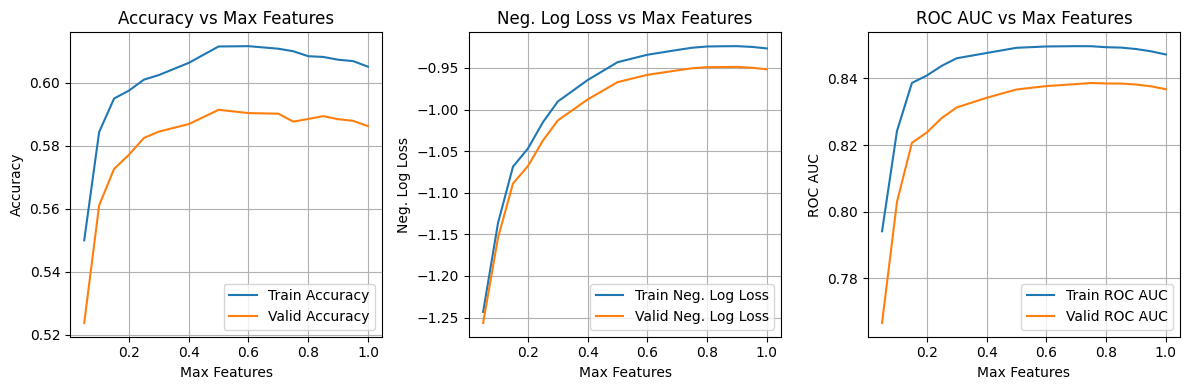

{'max_depth': 7, 'max_features': 0.5, 'max_leaf_nodes': 30, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


In [316]:
# Evaluation plots for grid-search for random forest_3
eval_plot(rf_cv_results_df3, 'max_features', 'Max Features')
print(rf_gsearch3.best_params_)

In [ ]:
# Grid-search for random forest_4
rf_gsearch4 = GridSearchCV(
    param_grid={'n_estimators': [800],
                'max_features': [0.85],
                'max_leaf_nodes': [30],
                'max_depth': [7],
                'max_samples': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                'min_samples_split': [2],
                'min_samples_leaf': [1]},
    estimator=rf_clf,
    cv=5,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

rf_gsearch4.fit(X_res_ohe_scaled, y_res)

rf_cv_results_df4 = cv_results(rf_gsearch4)
rf_cv_results_df4.sort_values(by="Rank_ACC", ascending=True)

,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
2,7,0.85,30,0.15,1,2,800,1,0.615566,0.598156,5,-0.921434,-0.946269,2,0.853043,0.841351,0.017411,0.024835,0.011691
1,7,0.85,30,0.10,1,2,800,2,0.615825,0.596476,10,-0.923112,-0.948154,5,0.852973,0.840826,0.019349,0.025042,0.012147
4,7,0.85,30,0.25,1,2,800,3,0.614468,0.596411,1,-0.920329,-0.945185,3,0.852579,0.841262,0.018057,0.024857,0.011317
3,7,0.85,30,0.20,1,2,800,4,0.615001,0.596152,3,-0.920443,-0.945539,1,0.853012,0.841421,0.018848,0.025096,0.011591
5,7,0.85,30,0.30,1,2,800,5,0.613886,0.593762,2,-0.920435,-0.945487,4,0.852211,0.840842,0.020125,0.025052,0.011369
6,7,0.85,30,0.40,1,2,800,6,0.612562,0.592728,4,-0.920969,-0.946128,6,0.851540,0.840293,0.019834,0.025159,0.011247
7,7,0.85,30,0.50,1,2,800,7,0.611253,0.591371,6,-0.921482,-0.946575,7,0.851009,0.839927,0.019883,0.025093,0.011083
8,7,0.85,30,0.60,1,2,800,8,0.609880,0.590466,7,-0.922126,-0.947146,8,0.850494,0.839480,0.019414,0.025021,0.011015
11,7,0.85,30,0.90,1,2,800,9,0.608362,0.590337,11,-0.923411,-0.948184,12,0.849554,0.838818,0.018025,0.024772,0.010736
9,7,0.85,30,0.70,1,2,800,10,0.609719,0.590014,8,-0.922692,-0.947662,9,0.850070,0.839149,0.019705,0.024971,0.010920


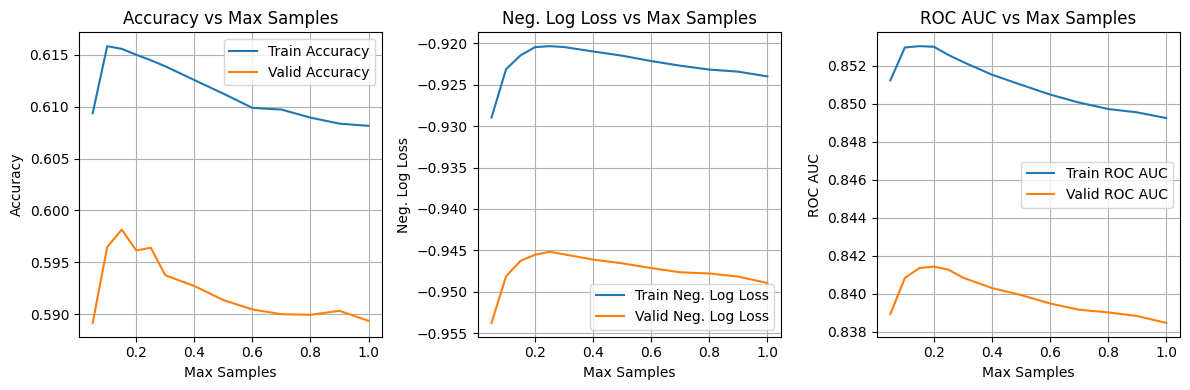

{'max_depth': 7, 'max_features': 0.85, 'max_leaf_nodes': 30, 'max_samples': 0.15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


In [318]:
# Evaluation plots for grid-search for random forest_4
eval_plot(rf_cv_results_df4, 'max_samples', 'Max Samples')
print(rf_gsearch4.best_params_)

In [376]:
# Grid-search for random forest_5
rf_gsearch5 = GridSearchCV(
    param_grid={'n_estimators': [800],
                'max_features': [0.85],
                'max_leaf_nodes': [30],
                'max_depth': [7],
                'max_samples': [0.2],
                'min_samples_split': [2],
                'min_samples_leaf': [1]},
    estimator=rf_clf,
    cv=5,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

rf_gsearch5.fit(X_res_ohe_scaled, y_res)

rf_cv_results_df5 = cv_results(rf_gsearch5)
rf_cv_results_df5.sort_values(by="Rank_ACC", ascending=True)

,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
0,7,0.85,30,0.2,1,2,800,1,0.615001,0.596152,1,-0.920443,-0.945539,1,0.853012,0.841421,0.018848,0.025096,0.011591


In [377]:
# Final model for random forest 
print(rf_gsearch5.best_params_)

rf_final = rf_gsearch5.best_estimator_
rf_final.fit(X_res_ohe_scaled, y_res)

{'max_depth': 7, 'max_features': 0.85, 'max_leaf_nodes': 30, 'max_samples': 0.2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


RandomForestClassifier(max_depth=7, max_features=0.85, max_leaf_nodes=30,
                       max_samples=0.2, n_estimators=800, random_state=57)

In [336]:
# Save the model
with open('./temp/01_random_forest.pkl', 'wb') as f:
  pickle.dump(rf_final, f)

In [337]:
# Load the model
with open('./temp/01_random_forest.pkl', 'rb') as f:
  rf_final = pickle.load(f)

In [378]:
# Evaluation metrics for random forest (1)
rf_train_pred, rf_test_pred = report_for_model1(rf_final, 
                                                X_res_ohe_scaled, y_res, 
                                                X_test_ohe_scaled, y_test)


--- Classification Report for Training Set ---
              precision    recall  f1-score   support

           0       0.64      0.72      0.68      3869
           1       0.53      0.52      0.52      3869
           2       0.67      0.52      0.59      3869
           3       0.62      0.69      0.65      3869

    accuracy                           0.61     15476
   macro avg       0.61      0.61      0.61     15476
weighted avg       0.61      0.61      0.61     15476


--- Classification Report for Testing Set ---
              precision    recall  f1-score   support

           0       0.83      0.71      0.76      2266
           1       0.35      0.47      0.40       867
           2       0.69      0.48      0.57       967
           3       0.27      0.57      0.37       306

    accuracy                           0.60      4406
   macro avg       0.53      0.56      0.52      4406
weighted avg       0.66      0.60      0.62      4406



In [379]:
# Evaluation metrics for random forest (2)
report_for_model2(rf_final, 
                  X_res_ohe_scaled, y_res, 
                  X_test_ohe_scaled, y_test)
print_auc_scores(rf_final, y_test, X_test_ohe_scaled)


--- Classification Report for Training Set ---
              precision   recall  f1-score      support
0               0.64144  0.72499   0.68066   3869.00000
1               0.52982  0.51667   0.52316   3869.00000
2               0.66744  0.52081   0.58508   3869.00000
3               0.61610  0.68648   0.64939   3869.00000
accuracy        0.61224  0.61224   0.61224      0.61224
macro avg       0.61370  0.61224   0.60957  15476.00000
weighted avg    0.61370  0.61224   0.60957  15476.00000

--- Classification Report for Testing Set ---
              precision   recall  f1-score     support
0               0.82636  0.70565   0.76125  2266.00000
1               0.35172  0.47059   0.40257   867.00000
2               0.68630  0.48190   0.56622   967.00000
3               0.27373  0.56536   0.36887   306.00000
accuracy        0.60054  0.60054   0.60054     0.60054
macro avg       0.53453  0.55587   0.52473  4406.00000
weighted avg    0.66384  0.60054   0.62061  4406.00000

--- Area Under t

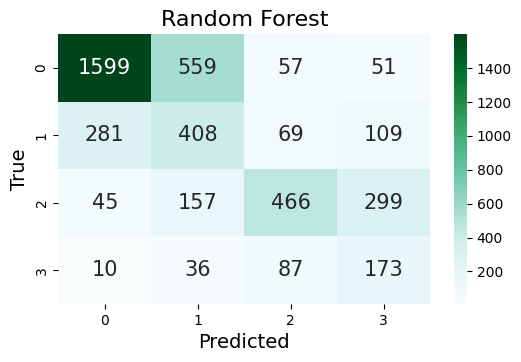

In [408]:
# Confusion matrix for random forest (testing set)
cm = confusion_matrix(y_test, rf_test_pred)
plt.figure(figsize=(6, 3.5))
sns.heatmap(cm, annot=True, cmap='BuGn', fmt='g', annot_kws={'size': 15})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Random Forest', fontsize=16)
plt.show()

##### 05_2 XGBoost

In [351]:
# Setting for xgboost
d_train = xgb.DMatrix(data = X_res_ohe_scaled, label = y_res)

params = {'max_depth': hp.quniform("max_depth", 2, 20, 1),
          'gamma': hp.uniform ('gamma', 15, 30),
          'reg_lambda': hp.uniform('reg_lambda', 0, 1),
          'subsample': hp.uniform('subsample', 0.1, 1),
          'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
          'min_child_weight': hp.quniform('min_child_weight', 1, 15, 1),
          'n_estimators': 2000,
          'seed': seed
}

def xgb_goal(params):
  model = XGBClassifier(
    objective = 'multi:softprob',
    num_class = 4,
    eval_metric = ['merror', 'mlogloss', 'auc'],
    n_estimators = int(params['n_estimators']),
    learning_rate = 0.01,
    max_depth = int(params['max_depth']),
    min_child_weight = int(params['min_child_weight']),
    gamma = params['gamma'],
    subsample = params['subsample'],
    colsample_bytree = params['colsample_bytree'],
    early_stopping_rounds = 50,
    reg_alpha = 0,
    reg_lambda = params['reg_lambda'],
    random_state = seed
  )

  xgb_cv_results_df = xgb.cv(
    params = model.get_xgb_params(),
    dtrain = d_train,
    nfold = 5,
    num_boost_round = model.get_params()['n_estimators'],
    early_stopping_rounds = model.get_params()['early_stopping_rounds'],
    seed = seed
  )

  best_score = min(xgb_cv_results_df['test-merror-mean'])
  best_round = len(xgb_cv_results_df)

  return {'loss': best_score, 'best_round': best_round, 'status': STATUS_OK}

trials = Trials()

best_hyperparams = fmin(fn = xgb_goal,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("Best Hyperparameters:", best_hyperparams)
print(f"Best round (with early stopping applied): {trials.best_trial['result']['best_round']}")

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [55:46<00:00, 33.47s/trial, best loss: 0.370573756120775] 
Best Hyperparameters: {'colsample_bytree': np.float64(0.7853692064636107), 'gamma': np.float64(15.415804105343618), 'max_depth': np.float64(20.0), 'min_child_weight': np.float64(6.0), 'reg_lambda': np.float64(0.05046587577124406), 'subsample': np.float64(0.9935324605796019)}
Best round (with early stopping applied): 540


In [ ]:
# xgboost_1
xgb_clf1 = XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    eval_metric=['merror', 'mlogloss', 'auc'],
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=20,
    min_child_weight=6,
    gamma=15,
    subsample=0.99,
    colsample_bytree=0.79,
    reg_alpha=0,
    reg_lambda=0.05,
    early_stopping_rounds=50,
    random_state=seed
    )

model = xgb_clf1

xgb_cv_results_df1 = xgb.cv(
    model.get_xgb_params(),
    d_train,
    nfold=5,
    num_boost_round=model.get_params()['n_estimators'],
    early_stopping_rounds=model.get_params()['early_stopping_rounds'],
    seed=seed
)

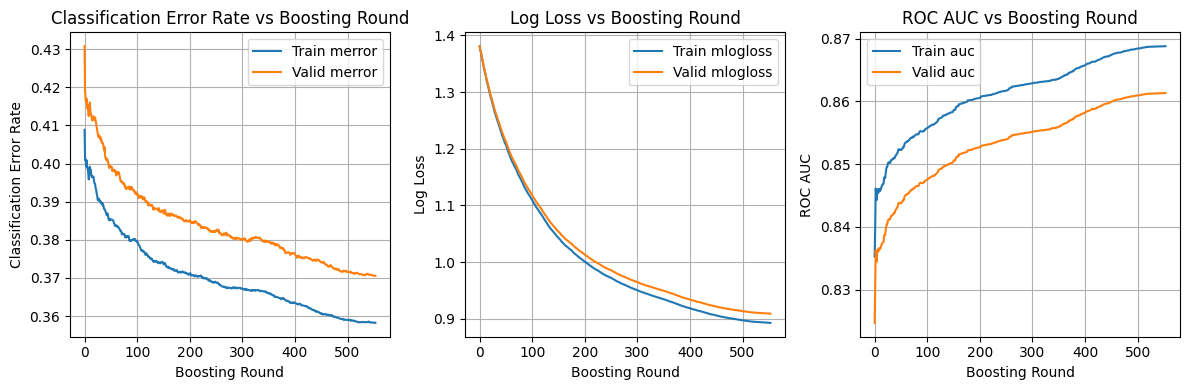

In [359]:
# Plots for xgboost_1
xgb_eval_plots(xgb_cv_results_df1)

In [360]:
# Evaluation metrics for xgboost_1
dftmp = xgb_cv_results_df1
dftmp.loc[[dftmp['test-merror-mean'].idxmin(), 
           dftmp['test-mlogloss-mean'].idxmin(), 
           dftmp['test-auc-mean'].idxmax()],
 ['train-merror-mean', 'test-merror-mean', 
  'train-mlogloss-mean', 'test-mlogloss-mean', 
  'train-auc-mean', 'test-auc-mean']]

,train-merror-mean,test-merror-mean,train-mlogloss-mean,test-mlogloss-mean,train-auc-mean,test-auc-mean
553,0.358264,0.370574,0.892883,0.909193,0.868805,0.86134
553,0.358264,0.370574,0.892883,0.909193,0.868805,0.86134
553,0.358264,0.370574,0.892883,0.909193,0.868805,0.86134


In [385]:
# Determine boosting round
tmp = 550
dftmp = xgb_cv_results_df1
print(dftmp.loc[tmp,['train-merror-mean', 'test-merror-mean', 
                     'train-mlogloss-mean', 'test-mlogloss-mean', 
                     'train-auc-mean', 'test-auc-mean']])
print(1 - xgb_cv_results_df1.loc[tmp, ['train-merror-mean', 'test-merror-mean']])

train-merror-mean      0.358248
test-merror-mean       0.370574
train-mlogloss-mean    0.893012
test-mlogloss-mean     0.909320
train-auc-mean         0.868793
test-auc-mean          0.861329
Name: 550, dtype: float64
train-merror-mean    0.641752
test-merror-mean     0.629426
Name: 550, dtype: float64


In [362]:
# Xgboost final model
xgb_final = XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    eval_metric=['merror', 'mlogloss', 'auc'],
    n_estimators=550,
    learning_rate=0.01,
    max_depth=20,
    min_child_weight=6,
    gamma=15,
    subsample=0.99,
    colsample_bytree=0.79,
    reg_alpha=0,
    reg_lambda=0.05,
    # early_stopping_rounds=50,
    random_state=seed
    )

print(xgb_final.get_xgb_params())

xgb_final.fit(X_res_ohe_scaled, y_res)

{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.79, 'device': None, 'eval_metric': ['merror', 'mlogloss', 'auc'], 'gamma': 15, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 20, 'max_leaves': None, 'min_child_weight': 6, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 57, 'reg_alpha': 0, 'reg_lambda': 0.05, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.99, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 4}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.79, device=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=['merror', 'mlogloss', 'auc'], feature_types=None,
              feature_weights=None, gamma=15, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=550,
              n_jobs=None, num_class=4, ...)

In [430]:
# Save the model
with open('./temp/02_xgboost.pkl', 'wb') as f:
  pickle.dump(xgb_final, f)

In [431]:
# Load the model
with open('./temp/02_xgboost.pkl', 'rb') as f:
  xgb_final = pickle.load(f)

In [391]:
# Evaluation metrics for xgboost (1)
xgb_train_pred, xgb_test_pred = report_for_model1(xgb_final, 
                                                  X_res_ohe_scaled, y_res, 
                                                  X_test_ohe_scaled, y_test)


--- Classification Report for Training Set ---
              precision    recall  f1-score   support

           0       0.65      0.72      0.69      3869
           1       0.54      0.52      0.53      3869
           2       0.67      0.66      0.66      3869
           3       0.74      0.69      0.71      3869

    accuracy                           0.65     15476
   macro avg       0.65      0.65      0.65     15476
weighted avg       0.65      0.65      0.65     15476


--- Classification Report for Testing Set ---
              precision    recall  f1-score   support

           0       0.83      0.71      0.76      2266
           1       0.37      0.51      0.43       867
           2       0.66      0.62      0.64       967
           3       0.31      0.39      0.34       306

    accuracy                           0.63      4406
   macro avg       0.54      0.55      0.54      4406
weighted avg       0.67      0.63      0.64      4406



In [392]:
# Evaluation metrics for xgboost (2)
report_for_model2(xgb_final, 
                  X_res_ohe_scaled, y_res, 
                  X_test_ohe_scaled, y_test)
print_auc_scores(xgb_final, y_test, X_test_ohe_scaled)


--- Classification Report for Training Set ---
              precision   recall  f1-score      support
0               0.65374  0.72318   0.68671   3869.00000
1               0.53526  0.52184   0.52846   3869.00000
2               0.67088  0.65909   0.66493   3869.00000
3               0.73668  0.68984   0.71249   3869.00000
accuracy        0.64849  0.64849   0.64849      0.64849
macro avg       0.64914  0.64849   0.64815  15476.00000
weighted avg    0.64914  0.64849   0.64815  15476.00000

--- Classification Report for Testing Set ---
              precision   recall  f1-score     support
0               0.83039  0.70653   0.76347  2266.00000
1               0.36776  0.50519   0.42566   867.00000
2               0.66482  0.61944   0.64133   967.00000
3               0.30570  0.38562   0.34104   306.00000
accuracy        0.62551  0.62551   0.62551     0.62551
macro avg       0.54217  0.55420   0.54287  4406.00000
weighted avg    0.66658  0.62551   0.64085  4406.00000

--- Area Under t

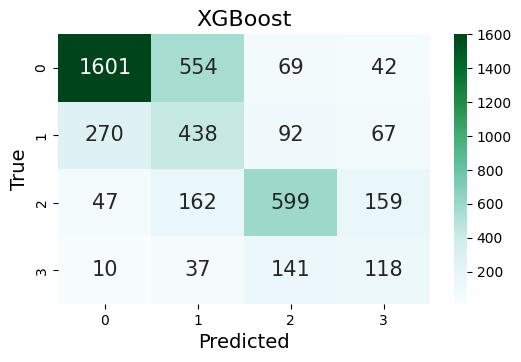

In [407]:
# Confusion matrix for xgboost (testing set)
cm = confusion_matrix(y_test, xgb_test_pred)
plt.figure(figsize=(6, 3.5))
sns.heatmap(cm, annot=True, cmap='BuGn', fmt='g', annot_kws={'size': 15})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('XGBoost', fontsize=16)
plt.show()



##### 05_3 Logistic regression

In [397]:
mlogit = LogisticRegression(max_iter=1000, random_state=seed)

In [398]:
# Grid-search for logistic regression_0
mlogit_gsearch0 = GridSearchCV(
    param_grid={'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                'penalty': [None, 'l2'],
                'C': [1]},
                estimator=mlogit,
                cv=5,
                scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
                refit='accuracy',
                return_train_score=True
) 

mlogit_gsearch0.fit(X_res_ohe_scaled, y_res)

mlogit_cv_results_df0 = cv_results(mlogit_gsearch0)
mlogit_cv_results_df0.sort_values(by="Rank_ACC", ascending=True)

,C,penalty,solver,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
6,1,l2,sag,1,0.602368,0.592147,3,-0.924467,-0.953958,8,0.843412,0.835221,0.010221,0.029491,0.008191
7,1,l2,saga,1,0.602417,0.592147,2,-0.924467,-0.953941,7,0.843412,0.835222,0.010270,0.029474,0.008191
5,1,l2,newton-cg,1,0.602385,0.592147,1,-0.924467,-0.953928,6,0.843412,0.835223,0.010237,0.029461,0.008189
0,1,None,lbfgs,4,0.602643,0.592083,7,-0.924415,-0.954593,2,0.843488,0.835291,0.010560,0.030179,0.008197
4,1,l2,lbfgs,5,0.602482,0.592018,4,-0.924474,-0.953962,5,0.843409,0.835228,0.010463,0.029489,0.008181
1,1,None,newton-cg,6,0.602482,0.591824,5,-0.924409,-0.954555,1,0.843491,0.835292,0.010657,0.030146,0.008199
3,1,None,saga,6,0.602546,0.591824,6,-0.924409,-0.954575,3,0.843491,0.835289,0.010722,0.030166,0.008202
2,1,None,sag,8,0.602562,0.591695,8,-0.924409,-0.954595,4,0.843491,0.835285,0.010867,0.030186,0.008205


In [399]:
# Grid-search for logistic regression_1
mlogit_gsearch1 = GridSearchCV(
    param_grid={'solver': ['lbfgs'],
                'penalty': ['l2'],
                'C': [0.01, 0.1, 1, 10]},
    estimator=mlogit,
    cv=5,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True
)

mlogit_gsearch1.fit(X_res_ohe_scaled, y_res)

mlogit_cv_results_df1 = cv_results(mlogit_gsearch1)
mlogit_cv_results_df1.sort_values(by="Rank_ACC", ascending=True)

,C,penalty,solver,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
3,10.00,l2,lbfgs,1,0.602675,0.592083,3,-0.924416,-0.954614,1,0.843477,0.835263,0.010593,0.030198,0.008214
2,1.00,l2,lbfgs,2,0.602482,0.592018,2,-0.924474,-0.953962,2,0.843409,0.835228,0.010463,0.029489,0.008181
1,0.10,l2,lbfgs,3,0.599687,0.590080,1,-0.927884,-0.953610,3,0.842480,0.834327,0.009607,0.025726,0.008153
0,0.01,l2,lbfgs,4,0.578703,0.568044,4,-0.977243,-0.993601,4,0.832509,0.824588,0.010658,0.016358,0.007921


In [400]:
# Grid-search for logistic regression_2
mlogit_gsearch2 = GridSearchCV(
    param_grid={'solver': ['lbfgs'],
                'penalty': ['l2'],
                'C': [10]},
    estimator=mlogit,
    cv=5,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True
)

mlogit_gsearch2.fit(X_res_ohe_scaled, y_res)

mlogit_cv_results_df2 = cv_results(mlogit_gsearch2)
mlogit_cv_results_df2.sort_values(by="Rank_ACC", ascending=True)

,C,penalty,solver,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
0,10,l2,lbfgs,1,0.602675,0.592083,1,-0.924416,-0.954614,1,0.843477,0.835263,0.010593,0.030198,0.008214


In [401]:
# Logistic regression final model
print(mlogit_gsearch2.best_params_)

mlogit_final = mlogit_gsearch2.best_estimator_
mlogit_final.fit(X_res_ohe_scaled, y_res)

{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


LogisticRegression(C=10, max_iter=1000, random_state=57)

In [432]:
# Save the model
with open('./temp/03_logistic_regression.pkl', 'wb') as f:
  pickle.dump(mlogit_final, f)

In [433]:
# Load the model
with open('./temp//03_logistic_regression.pkl', 'rb') as f:
  mlogit_final = pickle.load(f)

In [404]:
# Evaluation metrics for logistric regression (1)
mlogit_train_pred, mlogit_test_pred = report_for_model1(mlogit_final, 
                                                        X_res_ohe_scaled, y_res, 
                                                        X_test_ohe_scaled, y_test)


--- Classification Report for Training Set ---
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      3869
           1       0.50      0.53      0.51      3869
           2       0.63      0.53      0.58      3869
           3       0.60      0.64      0.62      3869

    accuracy                           0.60     15476
   macro avg       0.60      0.60      0.60     15476
weighted avg       0.60      0.60      0.60     15476


--- Classification Report for Testing Set ---
              precision    recall  f1-score   support

           0       0.84      0.69      0.76      2266
           1       0.35      0.48      0.41       867
           2       0.66      0.51      0.58       967
           3       0.24      0.47      0.31       306

    accuracy                           0.60      4406
   macro avg       0.52      0.54      0.52      4406
weighted avg       0.66      0.60      0.62      4406



In [405]:
# Evaluation metrics for logistric regression (2)
report_for_model2(mlogit_final, 
                  X_res_ohe_scaled, y_res, 
                  X_test_ohe_scaled, y_test)
print_auc_scores(mlogit_final, y_test, X_test_ohe_scaled)


--- Classification Report for Training Set ---
              precision   recall  f1-score      support
0               0.67760  0.70457   0.69083   3869.00000
1               0.50184  0.52856   0.51485   3869.00000
2               0.62929  0.53089   0.57591   3869.00000
3               0.60209  0.64022   0.62057   3869.00000
accuracy        0.60106  0.60106   0.60106      0.60106
macro avg       0.60271  0.60106   0.60054  15476.00000
weighted avg    0.60271  0.60106   0.60054  15476.00000

--- Classification Report for Testing Set ---
              precision   recall  f1-score     support
0               0.84148  0.69109   0.75890  2266.00000
1               0.35309  0.48097   0.40723   867.00000
2               0.66489  0.51499   0.58042   967.00000
3               0.23577  0.47386   0.31488   306.00000
accuracy        0.59601  0.59601   0.59601     0.59601
macro avg       0.52381  0.54023   0.51536  4406.00000
weighted avg    0.66455  0.59601   0.61969  4406.00000

--- Area Under t

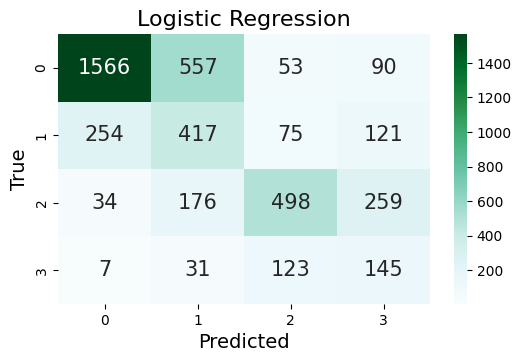

In [409]:
# Confusion matrix for logistic regression (testing set)
cm = confusion_matrix(y_test, mlogit_test_pred)
plt.figure(figsize=(6, 3.5))
sns.heatmap(cm, annot=True, cmap='BuGn', fmt='g', annot_kws={'size': 15})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Logistic Regression', fontsize=16)
plt.show()

##### 05_4 Support Vector Machine

In [410]:
svc = SVC(probability=True, random_state=seed)

In [412]:
# Undersampling for tuning
rus_2 = RandomUnderSampler(
    sampling_strategy={0: 100, 1: 100, 2: 100, 3: 100}, 
    random_state=seed
)

X_res_ohe_scaled_rus_2, y_res_rus_2 = rus_2.fit_resample(X_res_ohe_scaled, y_res)

In [ ]:
# Grid-search for SVM_0
svc_gsearch0 = GridSearchCV(
    param_grid={'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                'C': [1],
                'gamma': ['scale', 'auto'],
                'degree': [3],
                'coef0': [0]},
    estimator=svc,
    cv=5,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

svc_gsearch0.fit(X_res_ohe_scaled_rus_2, y_res_rus_2)

svc_cv_results_df0 = cv_results(svc_gsearch0)
svc_cv_results_df0.sort_values(by="Rank_ACC", ascending=True)

,C,coef0,degree,gamma,kernel,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
0,1,0,3,scale,linear,1,0.685625,0.4825,1,-0.965317,-1.106064,1,0.870339,0.776792,0.203125,0.140747,0.093547
4,1,0,3,auto,linear,1,0.685625,0.4825,1,-0.965317,-1.106064,1,0.870339,0.776792,0.203125,0.140747,0.093547
1,1,0,3,scale,rbf,3,0.783750,0.4800,6,-0.767106,-1.141974,6,0.951945,0.750417,0.303750,0.374869,0.201529
5,1,0,3,auto,rbf,4,0.595625,0.4625,4,-0.953342,-1.133313,5,0.859424,0.756292,0.133125,0.179971,0.103133
3,1,0,3,scale,sigmoid,5,0.470000,0.4550,3,-1.097491,-1.112744,3,0.780859,0.774542,0.015000,0.015253,0.006318
2,1,0,3,scale,poly,6,0.812500,0.4425,7,-0.850816,-1.237695,7,0.963799,0.710708,0.370000,0.386879,0.253091
7,1,0,3,auto,sigmoid,7,0.512500,0.4400,5,-1.031677,-1.136433,4,0.817240,0.756375,0.072500,0.104756,0.060865
6,1,0,3,auto,poly,8,0.311875,0.2750,8,-1.360719,-1.368448,8,0.613060,0.587792,0.036875,0.007730,0.025268


In [ ]:
# Grid-search for SVM_1
svc_gsearch1 = GridSearchCV(
    param_grid={'kernel': ['linear', 'rbf'],
                'C': [0.01, 0.1, 1, 10, 100, 500, 1000],
                'gamma': [0.001, 0.0015, 0.002, 'scale', 'auto'],
                'degree': [3],
                'coef0': [0]},
    estimator=svc,
    cv=5,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

svc_gsearch1.fit(X_res_ohe_scaled_rus_2, y_res_rus_2,)

svc_cv_results_df1 = cv_results(svc_gsearch1)
svc_cv_results_df1.sort_values(by="Rank_ACC", ascending=True)

,C,coef0,degree,gamma,kernel,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
41,100.00,0,3,0.001,rbf,1,0.641875,0.5050,1,-0.944660,-1.103674,1,0.866724,0.777458,0.136875,0.159014,0.089266
43,100.00,0,3,0.0015,rbf,2,0.670625,0.4925,8,-0.938664,-1.107924,8,0.872760,0.774417,0.178125,0.169260,0.098344
45,100.00,0,3,0.002,rbf,3,0.685625,0.4900,2,-0.933803,-1.105326,7,0.877578,0.774750,0.195625,0.171523,0.102828
51,500.00,0,3,0.001,rbf,4,0.698125,0.4875,9,-0.953745,-1.109802,9,0.877823,0.774125,0.210625,0.156057,0.103698
55,500.00,0,3,0.002,rbf,4,0.747500,0.4875,17,-0.949206,-1.122436,22,0.890643,0.765417,0.260000,0.173230,0.125227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,0.10,0,3,0.0015,rbf,63,0.378125,0.3650,69,-1.388980,-1.388517,69,0.258125,0.291958,0.013125,-0.000462,-0.033833
11,0.10,0,3,0.001,rbf,63,0.378750,0.3650,66,-1.387510,-1.387316,66,0.364505,0.384250,0.013750,-0.000193,-0.019745
5,0.01,0,3,0.002,rbf,63,0.377500,0.3650,63,-1.386294,-1.386294,63,0.500000,0.500000,0.012500,0.000000,0.000000
3,0.01,0,3,0.0015,rbf,63,0.378125,0.3650,63,-1.386294,-1.386294,63,0.500000,0.500000,0.013125,0.000000,0.000000


In [ ]:
# Grid-search for SVM_2
svc_gsearch2 = GridSearchCV(
    param_grid={'kernel': ['linear', 'rbf'],
                'C': [0.1, 1, 100],
                'gamma': [0.001, 0.005, 0.01, 'scale', 'auto'],
                'degree': [3],
                'coef0': [0]},
    estimator=svc,
    cv=5,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

svc_gsearch2.fit(X_res_ohe_scaled_rus_2, y_res_rus_2)

svc_cv_results_df2 = cv_results(svc_gsearch2)
svc_cv_results_df2.sort_values(by="Rank_ACC", ascending=True)

,C,coef0,degree,gamma,kernel,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
21,100.0,0,3,0.001,rbf,1,0.641875,0.5050,1,-0.944660,-1.103674,1,0.866724,0.777458,0.136875,0.159014,0.089266
23,100.0,0,3,0.005,rbf,2,0.746875,0.4950,7,-0.917014,-1.112716,7,0.903755,0.770042,0.251875,0.195702,0.133714
12,1.0,0,3,0.005,linear,3,0.685625,0.4825,2,-0.965317,-1.106064,2,0.870339,0.776792,0.203125,0.140747,0.093547
14,1.0,0,3,0.01,linear,3,0.685625,0.4825,2,-0.965317,-1.106064,2,0.870339,0.776792,0.203125,0.140747,0.093547
18,1.0,0,3,auto,linear,3,0.685625,0.4825,2,-0.965317,-1.106064,2,0.870339,0.776792,0.203125,0.140747,0.093547
16,1.0,0,3,scale,linear,3,0.685625,0.4825,2,-0.965317,-1.106064,2,0.870339,0.776792,0.203125,0.140747,0.093547
10,1.0,0,3,0.001,linear,3,0.685625,0.4825,2,-0.965317,-1.106064,2,0.870339,0.776792,0.203125,0.140747,0.093547
0,0.1,0,3,0.001,linear,8,0.606875,0.4800,8,-0.969557,-1.115638,8,0.852242,0.769792,0.126875,0.146081,0.082451
8,0.1,0,3,auto,linear,8,0.606875,0.4800,8,-0.969557,-1.115638,8,0.852242,0.769792,0.126875,0.146081,0.082451
2,0.1,0,3,0.005,linear,8,0.606875,0.4800,8,-0.969557,-1.115638,8,0.852242,0.769792,0.126875,0.146081,0.082451


In [426]:
# Grid-search for SVM_3
svc_gsearch3 = GridSearchCV(
    param_grid={'kernel': ['rbf'],
                'C': [100],
                'gamma': [0.001],
                'degree': [3],
                'coef0': [0]},
    estimator=svc,
    cv=5,
    scoring=['accuracy', 'neg_log_loss', 'roc_auc_ovr'],
    refit='accuracy',
    return_train_score=True,
    n_jobs=-1
)

svc_gsearch3.fit(X_res_ohe_scaled, y_res)

svc_cv_results_df3 = cv_results(svc_gsearch3)
svc_cv_results_df3.sort_values(by="Rank_ACC", ascending=True)

,C,coef0,degree,gamma,kernel,Rank_ACC,Train Accuracy,Valid Accuracy,Rank_NLL,Train Neg. Log Loss,Valid Neg. Log Loss,Rank_AUC,Train ROC AUC,Valid ROC AUC,diff_ACC,diff_NLL,diff_AUC
0,100,0,3,0.001,rbf,1,0.615873,0.599255,1,-0.90509,-0.942803,1,0.85176,0.840432,0.016618,0.037713,0.011327


In [427]:
# SVM fianl model
print(svc_gsearch3.best_params_)

svc_final = svc_gsearch3.best_estimator_
svc_final.fit(X_res_ohe_scaled, y_res)

{'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 0.001, 'kernel': 'rbf'}


SVC(C=100, coef0=0, gamma=0.001, probability=True, random_state=57)

In [434]:
# Save the model
with open('./temp/04_SVC.pkl', 'wb') as f:
  pickle.dump(svc_final, f)

In [435]:
# Load the model
with open('./temp/04_SVC.pkl', 'rb') as f:
  svc_final = pickle.load(f)

In [436]:
# Evaluation metrics for SVM (1)
svc_train_pred, svc_test_pred = report_for_model1(svc_final, 
                                                  X_res_ohe_scaled, y_res, 
                                                  X_test_ohe_scaled, y_test)


--- Classification Report for Training Set ---
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      3869
           1       0.51      0.58      0.54      3869
           2       0.66      0.53      0.58      3869
           3       0.64      0.65      0.64      3869

    accuracy                           0.61     15476
   macro avg       0.62      0.61      0.61     15476
weighted avg       0.62      0.61      0.61     15476


--- Classification Report for Testing Set ---
              precision    recall  f1-score   support

           0       0.84      0.69      0.75      2266
           1       0.35      0.51      0.42       867
           2       0.66      0.50      0.57       967
           3       0.25      0.44      0.32       306

    accuracy                           0.59      4406
   macro avg       0.52      0.54      0.51      4406
weighted avg       0.66      0.59      0.62      4406



In [437]:
# Evaluation metrics for SVM (2)
report_for_model2(svc_final, 
                  X_res_ohe_scaled, y_res, 
                  X_test_ohe_scaled, y_test)
print_auc_scores(svc_final, y_test, X_test_ohe_scaled)


--- Classification Report for Training Set ---
              precision   recall  f1-score      support
0               0.67910  0.70121   0.68998   3869.00000
1               0.50773  0.57689   0.54011   3869.00000
2               0.65637  0.52727   0.58478   3869.00000
3               0.63540  0.65314   0.64415   3869.00000
accuracy        0.61463  0.61463   0.61463      0.61463
macro avg       0.61965  0.61463   0.61475  15476.00000
weighted avg    0.61965  0.61463   0.61475  15476.00000

--- Classification Report for Testing Set ---
              precision   recall  f1-score     support
0               0.83765  0.68535   0.75388  2266.00000
1               0.34933  0.51211   0.41534   867.00000
2               0.66030  0.50052   0.56941   967.00000
3               0.24818  0.44444   0.31850   306.00000
accuracy        0.59396  0.59396   0.59396     0.59396
macro avg       0.52386  0.53561   0.51428  4406.00000
weighted avg    0.66170  0.59396   0.61654  4406.00000

--- Area Under t

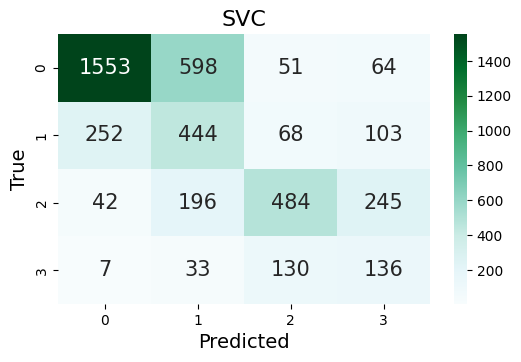

In [439]:
# Confusion matrix for SVC (testing set)
cm = confusion_matrix(y_test, svc_test_pred)
plt.figure(figsize=(6, 3.5))
sns.heatmap(cm, annot=True, cmap='BuGn', fmt='g', annot_kws={'size': 15})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('SVC', fontsize=16)
plt.savefig('111.png', bbox_inches='tight')
plt.show()

##### 05_5 Moderl performance comparison

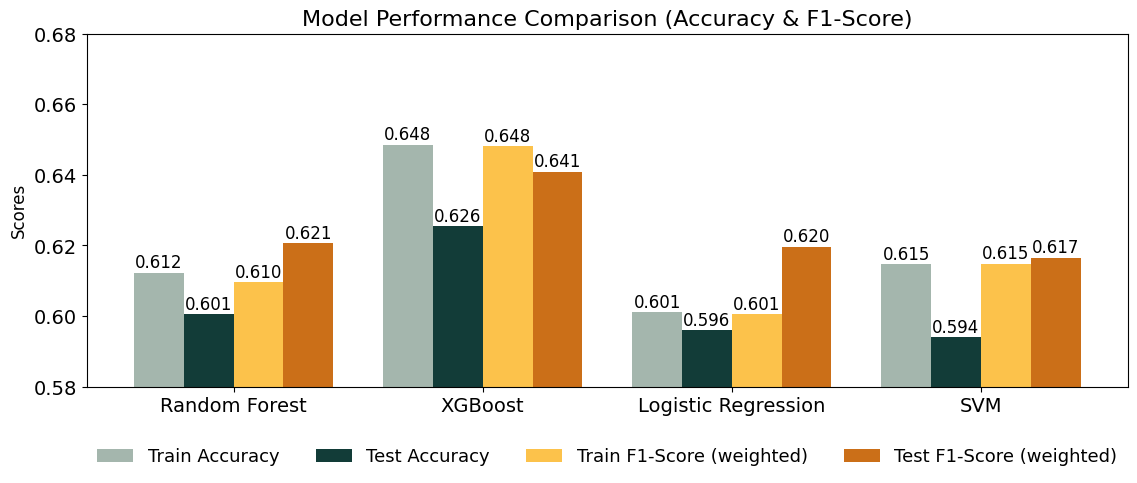

In [491]:
models = ['Random Forest', 'XGBoost', 'Logistic Regression', 'SVM']

accuracy_train = [
    accuracy_score(y_res, rf_train_pred),
    accuracy_score(y_res, xgb_train_pred),
    accuracy_score(y_res, mlogit_train_pred),
    accuracy_score(y_res, svc_train_pred)
]

accuracy_test = [
    accuracy_score(y_test, rf_test_pred),
    accuracy_score(y_test, xgb_test_pred),
    accuracy_score(y_test, mlogit_test_pred),
    accuracy_score(y_test, svc_test_pred)
]

f1_train = [
    f1_score(y_res, rf_train_pred, average='weighted'),
    f1_score(y_res, xgb_train_pred, average='weighted'),
    f1_score(y_res, mlogit_train_pred, average='weighted'),
    f1_score(y_res, svc_train_pred, average='weighted')
]

f1_test = [
    f1_score(y_test, rf_test_pred, average='weighted'),
    f1_score(y_test, xgb_test_pred, average='weighted'),
    f1_score(y_test, mlogit_test_pred, average='weighted'),
    f1_score(y_test, svc_test_pred, average='weighted')
]

model_results = pd.DataFrame({'Model': models,
                              'Accuracy (Train)': accuracy_train,
                              'Accuracy (Test)': accuracy_test,
                              'F1-Score (Train)': f1_train,
                              'F1-Score (Test)': f1_test})

plt.figure(figsize=(12, 5))

bar_width = 0.20
index = range(len(models))
plt.bar(index, accuracy_train, bar_width, label='Train Accuracy', alpha=0.8, color='#8EA499')
plt.bar([i + bar_width for i in index], accuracy_test, bar_width, label='Test Accuracy', color='#123C38')

plt.bar([i + 2 * bar_width for i in index], f1_train, bar_width, label='Train F1-Score (weighted)', alpha=0.8, color='#FCB31E')
plt.bar([i + 3 * bar_width for i in index], f1_test, bar_width, label='Test F1-Score (weighted)', color='#CB6F18')

for i in range(len(models)):
    plt.text(i, accuracy_train[i] + 0.0003, f'{accuracy_train[i]:.3f}', ha='center', va='bottom', fontsize=12)
    plt.text(i + bar_width, accuracy_test[i] + 0.0003, f'{accuracy_test[i]:.3f}', ha='center', va='bottom', fontsize=12)
    plt.text(i + 2 * bar_width, f1_train[i] + 0.0003, f'{f1_train[i]:.3f}', ha='center', va='bottom', fontsize=12)
    plt.text(i + 3 * bar_width, f1_test[i] + 0.0003, f'{f1_test[i]:.3f}', ha='center', va='bottom', fontsize=12)

plt.ylabel('Scores', fontsize=12)
plt.title('Model Performance Comparison (Accuracy & F1-Score)', fontsize=16)
plt.xticks([i + 1.5 * bar_width for i in index], models)
plt.ylim(0.58, 0.68)

plt.legend(loc='center', frameon=False, borderaxespad=-0.46, ncol=4, prop={'size': 13}, bbox_to_anchor=(0., -0.25, 1., .102))
plt.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.savefig('./plots/model_performance_comparison.png', bbox_inches='tight')
plt.show()

##### 05_6 Featuer importance

In [445]:
explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_test_ohe_scaled)

shap_values.shape

(4406, 34, 4)

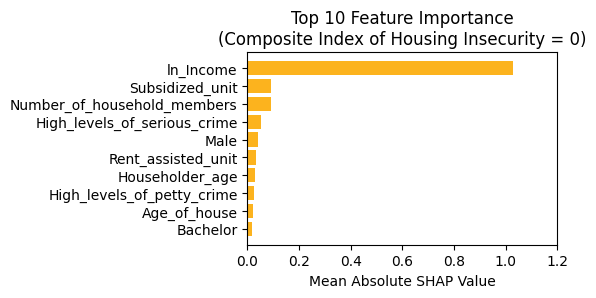

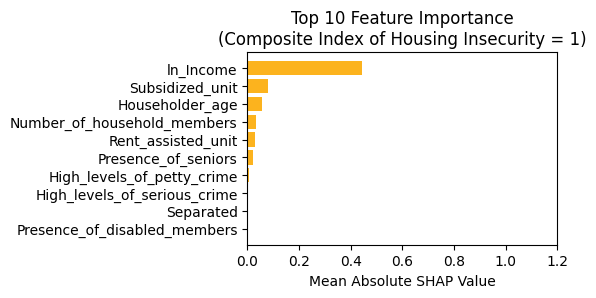

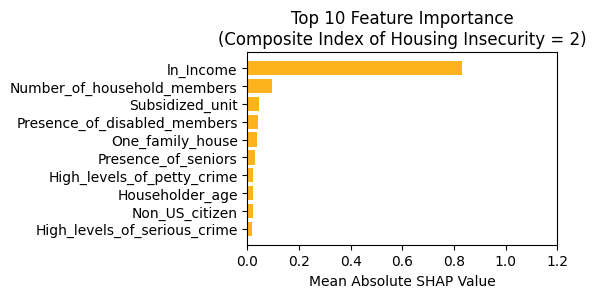

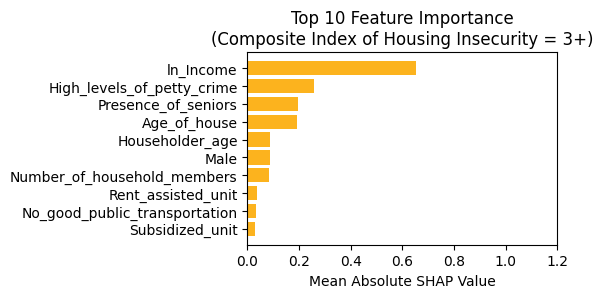

In [ ]:
# Plots for SHAP feature importance
feature_names = X_test_ohe_scaled.columns
plot_shap_barplot(shap_values, 0, 10, '#FCB31E', (4, 2.5), [0, 1.2], feature_names)
plot_shap_barplot(shap_values, 1, 10, '#FCB31E', (4, 2.5), [0, 1.2], feature_names)
plot_shap_barplot(shap_values, 2, 10, '#FCB31E', (4, 2.5), [0, 1.2], feature_names)
plot_shap_barplot(shap_values, 3, 10, '#FCB31E', (4, 2.5), [0, 1.2], feature_names)